# Transaction Velocity Anomaly Detection 
Business Scenario
Detect unusual transaction frequency and velocity patterns:
- Sudden bursts of transactions in short time periods
- Abnormal transaction amounts per hour/day
- Deviations from customer's 6-month baseline behavior
Key Features to Engineer:
1. Frequency Flag: Transactions in last 24h vs 6-month average
2. Velocity Score: LCY_AMT moved per hour/day, flagged if >3x normal
3. Combined Risk: Frequency × Velocity × Balance Stress Indicator

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# For better display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [3]:
# Load transaction data
try:
    # Try to load preprocessed data
    df = pd.read_csv('../data/processed/joined_table_preprocessed.csv')
    print(f"✅ Preprocessed data loaded! Shape: {df.shape}")
except FileNotFoundError:
    # Fallback to raw data
    df = pd.read_csv('../data/raw/joined_table.csv')
    print(f"✅ Raw data loaded! Shape: {df.shape}")

✅ Raw data loaded! Shape: (1304801, 15)


In [4]:
print("💳 TRANSACTION ANALYSIS")
print("="*60)

# Create Transaction_Date if not present
if 'Transaction_Date' not in df.columns:
    df['Transaction_Date'] = df['Last_Debit_Transaction_Date']
    print("Created Transaction_Date from Last_Debit_Transaction_Date")

💳 TRANSACTION ANALYSIS
Created Transaction_Date from Last_Debit_Transaction_Date


In [5]:
# Display data information
print("\n📊 DATASET INFORMATION")
print("="*60)
print(f"Total records: {df.shape[0]:,}")
print(f"Total columns: {df.shape[1]}")

# Check required columns
required_cols = ['Transaction_Amount', 'Transaction_Date', 'Current_Balance_LCY']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"❌ Missing required columns: {missing_cols}")
    print("Please ensure your dataset contains these columns.")
    raise KeyError(f"Missing columns: {missing_cols}")
else:
    print("✅ All required columns available")

# Check for Account_Number
if 'Account_Number' not in df.columns:
    print("⚠️ Account_Number not found. Creating customer IDs...")
    df['Account_Number'] = df.index.astype(str)

print(f"\n📋 Data Sample:")
display(df.head())


📊 DATASET INFORMATION
Total records: 1,304,801
Total columns: 16
✅ All required columns available

📋 Data Sample:


,Account_Number,Customer_Branch_Code,End_of_Month,Current_Balance_LCY,Transaction_Amount,Last_Debit_Transaction_Date,Last_Credit_Transaction_Date,Transaction_Channel_Name,Total_Transaction_Count,Debit_Credit_Flag,Channel,Longitude,Latitude,Community,Region,Transaction_Date
0,2045317750241665,1,202501,1848748,515500.0000,2025-02-03 00:00:00.000,2025-01-31 00:00:00.000,MISTRALUSER,1.0000,D,RIDGE TOWER,5.5597,-0.2002,Accra,Greater Accra Region,2025-02-03 00:00:00.000
1,2045317750241665,1,202501,1848748,113410.0000,2025-02-03 00:00:00.000,2025-01-31 00:00:00.000,GAKRONG,1.0000,D,RIDGE TOWER,5.5597,-0.2002,Accra,Greater Accra Region,2025-02-03 00:00:00.000
2,2045317750241665,1,202501,1848748,29539181.0000,2025-02-03 00:00:00.000,2025-01-31 00:00:00.000,MOFFEI,1.0000,C,RIDGE TOWER,5.5597,-0.2002,Accra,Greater Accra Region,2025-02-03 00:00:00.000
3,2045317750241665,1,202501,1848748,343612.0000,2025-02-03 00:00:00.000,2025-01-31 00:00:00.000,ATMUSER,2.0000,D,RIDGE TOWER,5.5597,-0.2002,Accra,Greater Accra Region,2025-02-03 00:00:00.000
4,2045317750241665,1,202501,1848748,103100000.0000,2025-02-03 00:00:00.000,2025-01-31 00:00:00.000,AKUWORNU,1.0000,C,RIDGE TOWER,5.5597,-0.2002,Accra,Greater Accra Region,2025-02-03 00:00:00.000


In [6]:
# Data Preparation
print("🔄 PREPARING DATA FOR VELOCITY ANALYSIS")
print("="*60)

# Convert data types
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], errors='coerce')
df['Transaction_Amount'] = pd.to_numeric(df['Transaction_Amount'], errors='coerce')
df['Current_Balance_LCY'] = pd.to_numeric(df['Current_Balance_LCY'], errors='coerce')

# Sort by customer and date
df = df.sort_values(['Account_Number', 'Transaction_Date']).reset_index(drop=True)

# Create time-based features
df['Transaction_Hour'] = df['Transaction_Date'].dt.hour
df['Transaction_Day'] = df['Transaction_Date'].dt.date
df['Transaction_Week'] = df['Transaction_Date'].dt.isocalendar().week
df['Transaction_Month'] = df['Transaction_Date'].dt.to_period('M')

print(f"✅ Data prepared. Unique customers: {df['Account_Number'].nunique():,}")
print(f"   • Date range: {df['Transaction_Date'].min()} to {df['Transaction_Date'].max()}")
print(f"   • Time span: {(df['Transaction_Date'].max() - df['Transaction_Date'].min()).days} days")

🔄 PREPARING DATA FOR VELOCITY ANALYSIS
✅ Data prepared. Unique customers: 3,893
   • Date range: 1800-01-01 00:00:00 to 2025-11-03 00:00:00
   • Time span: 82486 days


# 1.1 Calculate 6-Month Customer Baselines 
Establish normal behavior patterns for each customer over 6 months.

In [7]:
print("\n📈 CALCULATING 6-MONTH CUSTOMER BASELINES")
print("="*60)

# %%
# Calculate baseline statistics for each customer
print("Calculating monthly transaction patterns...")

# Create monthly aggregation
monthly_stats = df.groupby(['Account_Number', 'Transaction_Month']).agg({
    'Transaction_Date': 'count',
    'Transaction_Amount': ['sum', 'mean', 'std'],
    'Current_Balance_LCY': 'mean'
}).reset_index()

# Flatten column names
monthly_stats.columns = ['Account_Number', 'Month', 
                         'Monthly_Count', 'Monthly_Amount_Sum',
                         'Monthly_Amount_Mean', 'Monthly_Amount_Std',
                         'Avg_Balance']

print(f"✅ Monthly stats calculated for {monthly_stats['Account_Number'].nunique():,} customers")

# %%
# Calculate 6-month rolling averages
print("\nCalculating 6-month rolling averages...")

def calculate_rolling_averages(group):
    group = group.sort_values('Month')
    
    # 6-month rolling averages
    group['SixMonth_Avg_Count'] = group['Monthly_Count'].rolling(window=6, min_periods=1).mean()
    group['SixMonth_Avg_Amount'] = group['Monthly_Amount_Sum'].rolling(window=6, min_periods=1).mean()
    group['SixMonth_Std_Count'] = group['Monthly_Count'].rolling(window=6, min_periods=1).std()
    group['SixMonth_Std_Amount'] = group['Monthly_Amount_Sum'].rolling(window=6, min_periods=1).std()
    
    # Fill NaN with overall average
    group['SixMonth_Avg_Count'] = group['SixMonth_Avg_Count'].fillna(group['Monthly_Count'].mean())
    group['SixMonth_Avg_Amount'] = group['SixMonth_Avg_Amount'].fillna(group['Monthly_Amount_Sum'].mean())
    
    return group

monthly_stats = monthly_stats.groupby('Account_Number', group_keys=False).apply(calculate_rolling_averages)

print(f"✅ 6-month rolling averages calculated")

# %%
# Calculate hourly and daily patterns
print("\nCalculating hourly/daily patterns...")

# Add hour and day to original data
df['Hour'] = df['Transaction_Date'].dt.hour
df['DayOfWeek'] = df['Transaction_Date'].dt.dayofweek
df['Is_Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Calculate customer hourly patterns (for time of day analysis)
hourly_patterns = df.groupby(['Account_Number', 'Hour']).agg({
    'Transaction_Amount': ['count', 'sum', 'mean']
}).reset_index()

hourly_patterns.columns = ['Account_Number', 'Hour', 
                          'Hourly_Count', 'Hourly_Amount_Sum', 'Hourly_Amount_Mean']

# Normalize hourly counts to percentages
hourly_totals = hourly_patterns.groupby('Account_Number')['Hourly_Count'].sum().reset_index()
hourly_totals.columns = ['Account_Number', 'Total_Hourly_Count']
hourly_patterns = hourly_patterns.merge(hourly_totals, on='Account_Number')
hourly_patterns['Hourly_Percentage'] = hourly_patterns['Hourly_Count'] / hourly_patterns['Total_Hourly_Count']

print(f"✅ Hourly patterns calculated for {hourly_patterns['Account_Number'].nunique():,} customers")

# %%
# Create customer baseline summary
print("\nCreating customer baseline summary...")

customer_baselines = monthly_stats.groupby('Account_Number').agg({
    'SixMonth_Avg_Count': 'last',  # Most recent 6-month average
    'SixMonth_Avg_Amount': 'last',
    'SixMonth_Std_Count': 'last',
    'SixMonth_Std_Amount': 'last',
    'Avg_Balance': 'mean'
}).reset_index()

customer_baselines.columns = ['Account_Number', 'Baseline_Monthly_Count',
                             'Baseline_Monthly_Amount', 'Baseline_Std_Count',
                             'Baseline_Std_Amount', 'Avg_Balance_6M']

print(f"✅ Customer baselines created")
print(f"\n📊 Baseline Statistics:")
print(f"   • Avg monthly transactions per customer: {customer_baselines['Baseline_Monthly_Count'].mean():.1f}")
print(f"   • Avg monthly amount per customer: {customer_baselines['Baseline_Monthly_Amount'].mean():,.0f}")
print(f"   • Customers with no variance (std=0): {(customer_baselines['Baseline_Std_Count'] == 0).sum():,}")


📈 CALCULATING 6-MONTH CUSTOMER BASELINES
Calculating monthly transaction patterns...
✅ Monthly stats calculated for 3,893 customers

Calculating 6-month rolling averages...
✅ 6-month rolling averages calculated

Calculating hourly/daily patterns...
✅ Hourly patterns calculated for 3,893 customers

Creating customer baseline summary...
✅ Customer baselines created

📊 Baseline Statistics:
   • Avg monthly transactions per customer: 152.2
   • Avg monthly amount per customer: 943,882,866
   • Customers with no variance (std=0): 431


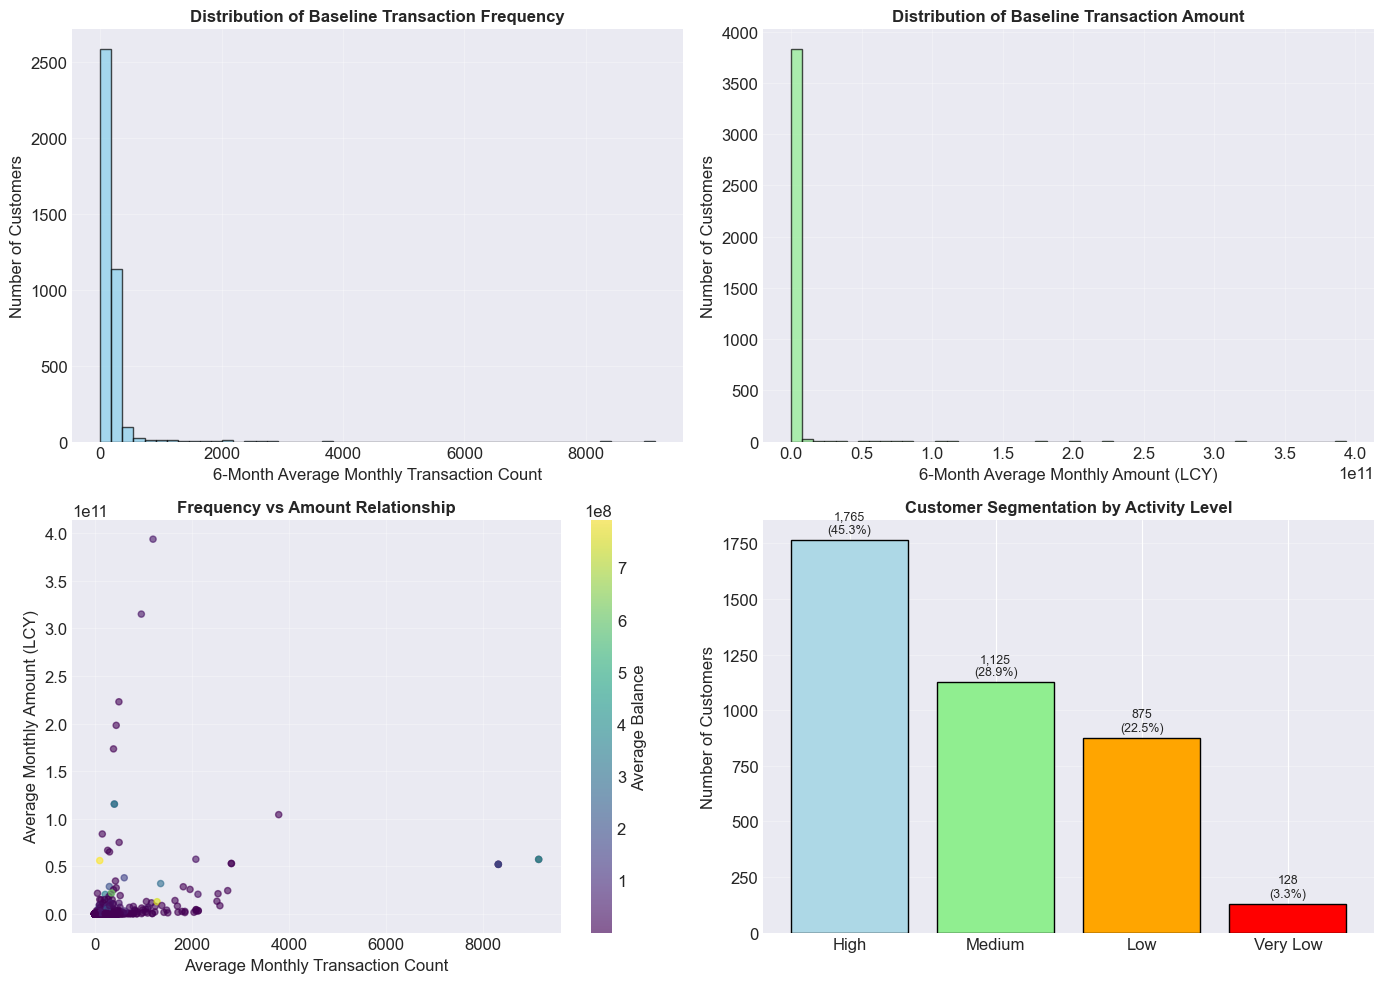

In [8]:
# Visualize Baseline Distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Baseline Monthly Transaction Count Distribution
axes[0,0].hist(customer_baselines['Baseline_Monthly_Count'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0,0].set_xlabel('6-Month Average Monthly Transaction Count')
axes[0,0].set_ylabel('Number of Customers')
axes[0,0].set_title('Distribution of Baseline Transaction Frequency', fontsize=12, fontweight='bold')
axes[0,0].grid(alpha=0.3)

# Plot 2: Baseline Monthly Amount Distribution
axes[0,1].hist(customer_baselines['Baseline_Monthly_Amount'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0,1].set_xlabel('6-Month Average Monthly Amount (LCY)')
axes[0,1].set_ylabel('Number of Customers')
axes[0,1].set_title('Distribution of Baseline Transaction Amount', fontsize=12, fontweight='bold')
axes[0,1].grid(alpha=0.3)

# Plot 3: Relationship between Frequency and Amount
scatter = axes[1,0].scatter(customer_baselines['Baseline_Monthly_Count'], 
                           customer_baselines['Baseline_Monthly_Amount'],
                           c=customer_baselines['Avg_Balance_6M'],
                           cmap='viridis', alpha=0.6, s=20)
axes[1,0].set_xlabel('Average Monthly Transaction Count')
axes[1,0].set_ylabel('Average Monthly Amount (LCY)')
axes[1,0].set_title('Frequency vs Amount Relationship', fontsize=12, fontweight='bold')
axes[1,0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1,0], label='Average Balance')

# Plot 4: Customer Segmentation by Activity Level
def categorize_activity_level(count):
    if count <= 5:
        return 'Very Low'
    elif count <= 20:
        return 'Low'
    elif count <= 100:
        return 'Medium'
    else:
        return 'High'

customer_baselines['Activity_Level'] = customer_baselines['Baseline_Monthly_Count'].apply(categorize_activity_level)
activity_counts = customer_baselines['Activity_Level'].value_counts()

colors = ['lightblue', 'lightgreen', 'orange', 'red']
bars = axes[1,1].bar(range(len(activity_counts)), activity_counts.values, color=colors, edgecolor='black')
axes[1,1].set_xticks(range(len(activity_counts)))
axes[1,1].set_xticklabels(activity_counts.index)
axes[1,1].set_ylabel('Number of Customers')
axes[1,1].set_title('Customer Segmentation by Activity Level', fontsize=12, fontweight='bold')
axes[1,1].grid(alpha=0.3, axis='y')

# Add value labels
for i, (bar, count) in enumerate(zip(bars, activity_counts.values)):
    pct = count / len(customer_baselines) * 100
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(activity_counts.values)*0.01,
                  f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 2.1 Detect Transaction Frequency Anomalies
Identify unusual transaction bursts in 24-hour periods.

In [9]:
print("\n📊 FREQUENCY ANALYSIS: 24-HOUR TRANSACTION BURSTS")
print("="*60)

# Calculate rolling 24-hour transaction counts
print("Calculating 24-hour rolling transaction counts...")

# This can be computationally intensive, so we'll use efficient methods
# First, ensure data is sorted
df = df.sort_values(['Account_Number', 'Transaction_Date']).reset_index(drop=True)

# For efficiency, we'll calculate for a sample of customers or use vectorized operations
sample_size = min(5000, df['Account_Number'].nunique())
sample_customers = df['Account_Number'].drop_duplicates().sample(sample_size, random_state=42)
df_sample = df[df['Account_Number'].isin(sample_customers)].copy()

print(f"📊 Analyzing {sample_size:,} customer sample ({len(df_sample):,} transactions)")

# %%
# Calculate 24-hour rolling window for each customer
print("\nCalculating 24-hour transaction windows...")

def calculate_24h_counts(group):
    """Calculate number of transactions in previous 24 hours for each transaction"""
    dates = group['Transaction_Date'].values
    counts = np.zeros(len(dates))
    
    for i, current_date in enumerate(dates):
        # Count transactions in previous 24 hours
        mask = (dates >= current_date - pd.Timedelta(hours=24)) & (dates <= current_date)
        counts[i] = mask.sum()
    
    group['24h_Transaction_Count'] = counts
    return group

# Apply to sample (this is the computationally intensive part)
df_sample = df_sample.groupby('Account_Number', group_keys=False).apply(calculate_24h_counts)

print(f"✅ 24-hour transaction counts calculated")

# %%
# Calculate daily transaction counts (more efficient for full dataset)
print("\nCalculating daily transaction patterns...")

# Create daily transaction counts
daily_counts = df.groupby(['Account_Number', 'Transaction_Day']).size().reset_index(name='Daily_Count')

# Calculate 6-month average daily count per customer
daily_counts['Transaction_Month'] = pd.to_datetime(daily_counts['Transaction_Day']).dt.to_period('M')

# Get 6-month average
customer_daily_avg = daily_counts.groupby('Account_Number').agg({
    'Daily_Count': 'mean'
}).reset_index()
customer_daily_avg.columns = ['Account_Number', 'Baseline_Daily_Count']

print(f"✅ Daily transaction patterns calculated for {len(customer_daily_avg):,} customers")

# %%
# Merge daily averages back to transactions
df = df.merge(customer_daily_avg, on='Account_Number', how='left')

# For sampled data, also calculate frequency flag
df_sample = df_sample.merge(customer_daily_avg, on='Account_Number', how='left')

# Calculate Frequency Flag: 24h count vs 6-month daily average
df_sample['Frequency_Ratio'] = df_sample['24h_Transaction_Count'] / df_sample['Baseline_Daily_Count']

# Handle cases where baseline is 0
df_sample['Frequency_Ratio'] = df_sample['Frequency_Ratio'].replace([np.inf, -np.inf], 100)  # Large number for flag
df_sample['Frequency_Ratio'] = df_sample['Frequency_Ratio'].fillna(100)

# Create frequency flag (binary)
frequency_threshold = 3.0  # 3x normal daily average
df_sample['Frequency_Flag'] = (df_sample['Frequency_Ratio'] > frequency_threshold).astype(int)

print(f"✅ Frequency analysis completed (threshold: {frequency_threshold}x normal)")
print(f"📊 Frequency Flag Statistics:")
print(f"   • Transactions with high frequency: {df_sample['Frequency_Flag'].sum():,}")
print(f"   • Percentage flagged: {df_sample['Frequency_Flag'].sum()/len(df_sample)*100:.2f}%")
print(f"   • Average frequency ratio: {df_sample['Frequency_Ratio'].mean():.2f}")
print(f"   • Maximum frequency ratio: {df_sample['Frequency_Ratio'].max():.2f}")

# %%
# Analyze frequency patterns
print("\n🔍 Analyzing Frequency Patterns:")

# Group by customer to find those with frequent bursts
customer_frequency = df_sample.groupby('Account_Number').agg({
    'Frequency_Flag': 'sum',
    '24h_Transaction_Count': 'max',
    'Baseline_Daily_Count': 'first'
}).reset_index()

customer_frequency.columns = ['Account_Number', 'High_Frequency_Events',
                             'Max_24h_Count', 'Baseline_Daily_Count']

# Find customers with multiple high-frequency events
multi_event_customers = customer_frequency[customer_frequency['High_Frequency_Events'] > 1]
print(f"   • Customers with >1 high-frequency event: {len(multi_event_customers):,}")
print(f"   • Maximum 24h transactions observed: {customer_frequency['Max_24h_Count'].max():.0f}")

# Analyze by time of day
if len(df_sample) > 0:
    high_freq_by_hour = df_sample[df_sample['Frequency_Flag'] == 1].groupby('Hour').size()
    if len(high_freq_by_hour) > 0:
        peak_hours = high_freq_by_hour.nlargest(3)
        print(f"   • Peak hours for high-frequency events: {list(peak_hours.index)}")


📊 FREQUENCY ANALYSIS: 24-HOUR TRANSACTION BURSTS
Calculating 24-hour rolling transaction counts...
📊 Analyzing 3,893 customer sample (1,304,801 transactions)

Calculating 24-hour transaction windows...
✅ 24-hour transaction counts calculated

Calculating daily transaction patterns...
✅ Daily transaction patterns calculated for 3,893 customers
✅ Frequency analysis completed (threshold: 3.0x normal)
📊 Frequency Flag Statistics:
   • Transactions with high frequency: 2,841
   • Percentage flagged: 0.22%
   • Average frequency ratio: 1.10
   • Maximum frequency ratio: 3.27

🔍 Analyzing Frequency Patterns:
   • Customers with >1 high-frequency event: 11
   • Maximum 24h transactions observed: 9141
   • Peak hours for high-frequency events: [0]


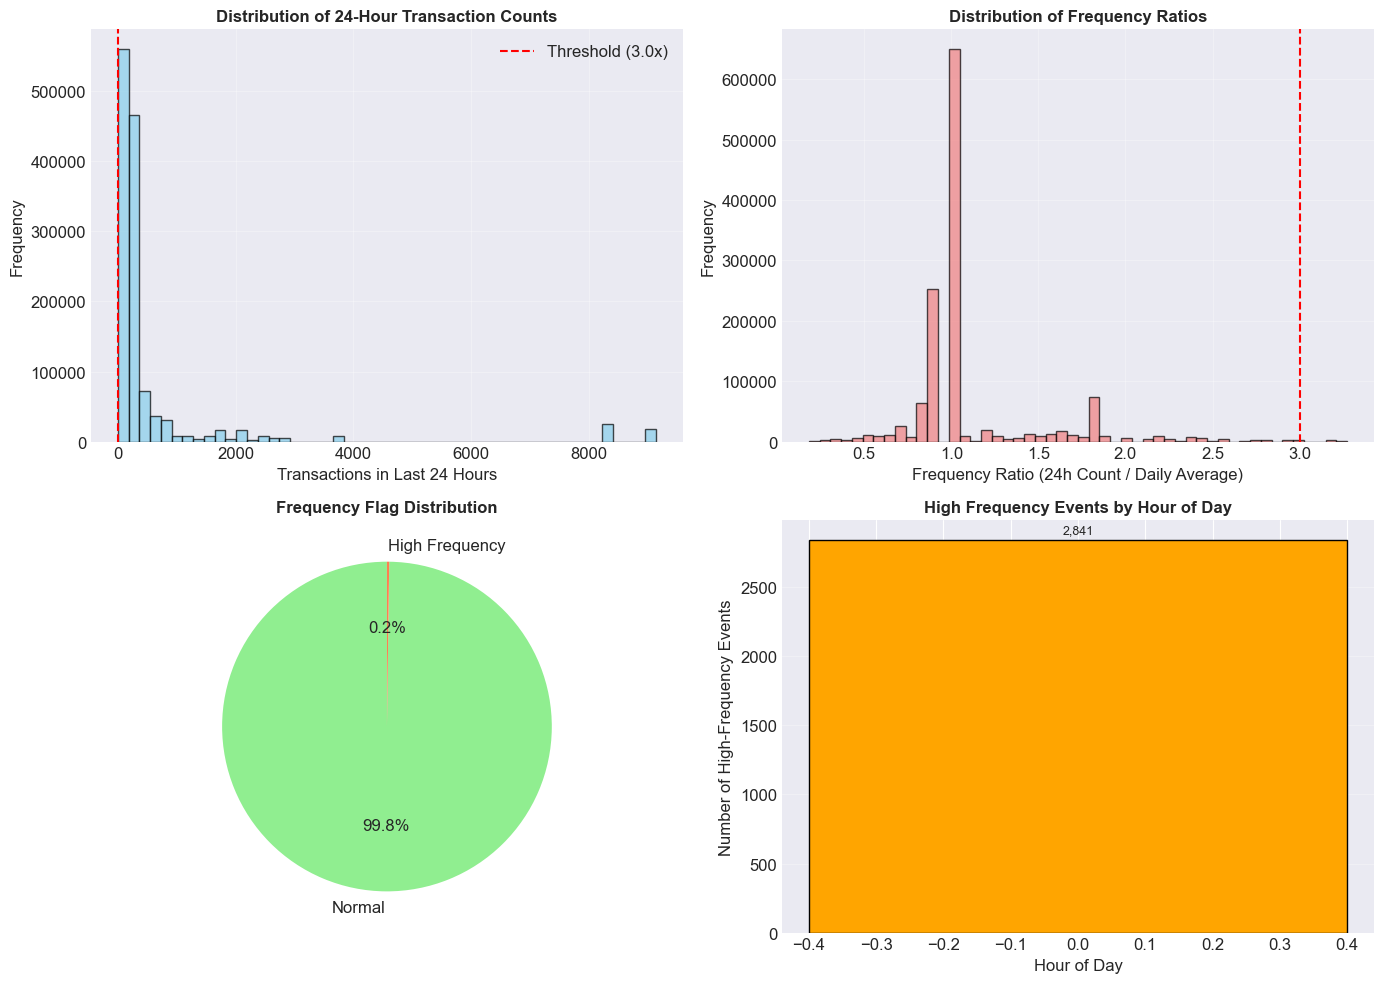

In [10]:
# Visualize Frequency Analysis Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: 24-Hour Transaction Count Distribution
axes[0,0].hist(df_sample['24h_Transaction_Count'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0,0].set_xlabel('Transactions in Last 24 Hours')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of 24-Hour Transaction Counts', fontsize=12, fontweight='bold')
axes[0,0].axvline(frequency_threshold, color='red', linestyle='--', 
                 label=f'Threshold ({frequency_threshold}x)')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Plot 2: Frequency Ratio Distribution
valid_ratios = df_sample[df_sample['Frequency_Ratio'] < 20]['Frequency_Ratio']  # Cap for visualization
axes[0,1].hist(valid_ratios, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0,1].set_xlabel('Frequency Ratio (24h Count / Daily Average)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Frequency Ratios', fontsize=12, fontweight='bold')
axes[0,1].axvline(frequency_threshold, color='red', linestyle='--')
axes[0,1].grid(alpha=0.3)

# Plot 3: Frequency Flag Distribution
flag_counts = df_sample['Frequency_Flag'].value_counts()
colors = ['lightgreen', 'coral']
axes[1,0].pie(flag_counts.values, labels=['Normal', 'High Frequency'], 
              autopct='%1.1f%%', startangle=90, colors=colors)
axes[1,0].set_title('Frequency Flag Distribution', fontsize=12, fontweight='bold')

# Plot 4: High Frequency Events by Hour
if 'high_freq_by_hour' in locals() and len(high_freq_by_hour) > 0:
    bars = axes[1,1].bar(high_freq_by_hour.index, high_freq_by_hour.values, color='orange', edgecolor='black')
    axes[1,1].set_xlabel('Hour of Day')
    axes[1,1].set_ylabel('Number of High-Frequency Events')
    axes[1,1].set_title('High Frequency Events by Hour of Day', fontsize=12, fontweight='bold')
    axes[1,1].grid(alpha=0.3, axis='y')
    
    # Add value labels for top bars
    for i, (hour, count) in enumerate(zip(high_freq_by_hour.index, high_freq_by_hour.values)):
        if i < 5:  # Label top 5
            axes[1,1].text(hour, count + max(high_freq_by_hour.values)*0.01, 
                          f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 3.1 Calculate Transaction Velocity
Measure transaction amount moved per hour/day and compare to baseline.

In [ ]:
# Calculate Transaction Velocity - CLEAN VERSION
print("\n🚀 CALCULATING TRANSACTION VELOCITY...")
print("="*60)

# Make sure we have datetime columns properly set up
if 'Transaction_Date' in df.columns:
    if not pd.api.types.is_datetime64_any_dtype(df['Transaction_Date']):
        df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])
    
    # Extract date components
    df['Transaction_Hour'] = df['Transaction_Date'].dt.hour
    df['Transaction_Day'] = df['Transaction_Date'].dt.date
    df['Transaction_Month'] = df['Transaction_Date'].dt.to_period('M')
    
    # 1. Calculate Baseline (average monthly amount per customer)
    print("\n📊 Calculating baseline monthly amounts per customer...")
    
    # Calculate monthly totals per customer
    monthly_totals = df.groupby(['Account_Number', 'Transaction_Month'])['Transaction_Amount'].sum().reset_index()
    monthly_totals.rename(columns={'Transaction_Amount': 'Monthly_Amount'}, inplace=True)
    
    # Calculate average monthly amount per customer (baseline)
    baseline_monthly = monthly_totals.groupby('Account_Number')['Monthly_Amount'].mean().reset_index()
    baseline_monthly.rename(columns={'Monthly_Amount': 'Baseline_Monthly_Amount'}, inplace=True)
    
    # Merge baseline back to main dataframe
    df = df.merge(baseline_monthly, on='Account_Number', how='left')
    
    print(f"   • Calculated baseline for {len(baseline_monthly):,} unique customers")
    print(f"   • Average baseline amount: {baseline_monthly['Baseline_Monthly_Amount'].mean():,.2f}")
    
    # 2. Calculate Daily Velocity
    print("\n📈 Calculating daily transaction velocity...")
    
    # Calculate daily totals per customer
    daily_totals = df.groupby(['Account_Number', 'Transaction_Day'])['Transaction_Amount'].sum().reset_index()
    daily_totals.rename(columns={'Transaction_Amount': 'Daily_Amount_Sum'}, inplace=True)
    
    # Merge baseline into daily_totals
    daily_velocity = daily_totals.merge(baseline_monthly, on='Account_Number', how='left')
    
    # Calculate daily velocity ratio
    daily_velocity['Daily_Velocity_Ratio'] = daily_velocity['Daily_Amount_Sum'] / (daily_velocity['Baseline_Monthly_Amount'] / 30)  # Compare to average daily (monthly/30)
    
    # Create daily velocity flag
    daily_velocity_threshold = 3.0  # 3x normal daily amount
    daily_velocity['Daily_Velocity_Flag'] = daily_velocity['Daily_Velocity_Ratio'].apply(
        lambda x: 1 if x > daily_velocity_threshold else 0
    )
    
    print(f"   • Analyzed {len(daily_velocity):,} daily transactions")
    print(f"   • {daily_velocity['Daily_Velocity_Flag'].sum():,} days exceed velocity threshold")
    print(f"   • Max daily velocity ratio: {daily_velocity['Daily_Velocity_Ratio'].max():.2f}x")
    
    # 3. Calculate Hourly Velocity
    print("\n⏰ Calculating hourly transaction velocity...")
    
    # Calculate hourly totals per customer
    hourly_totals = df.groupby(['Account_Number', 'Transaction_Day', 'Transaction_Hour'])['Transaction_Amount'].sum().reset_index()
    hourly_totals.rename(columns={'Transaction_Amount': 'Hourly_Amount_Sum'}, inplace=True)
    
    # Calculate average daily amount for scaling
    avg_daily_per_customer = daily_totals.groupby('Account_Number')['Daily_Amount_Sum'].mean().reset_index()
    avg_daily_per_customer.rename(columns={'Daily_Amount_Sum': 'Avg_Daily_Amount'}, inplace=True)
    
    # Merge for hourly velocity calculation
    hourly_velocity = hourly_totals.merge(avg_daily_per_customer, on='Account_Number', how='left')
    
    # Calculate hourly velocity ratio
    # Compare hourly amount to what would be expected for that hour based on daily average
    # Assuming 8 active hours per day for scaling
    hourly_velocity['Hourly_Velocity_Ratio'] = hourly_velocity['Hourly_Amount_Sum'] / (hourly_velocity['Avg_Daily_Amount'] / 8)
    
    # Create hourly velocity flag
    hourly_velocity_threshold = 5.0  # 5x normal hourly amount
    hourly_velocity['Hourly_Velocity_Flag'] = hourly_velocity['Hourly_Velocity_Ratio'].apply(
        lambda x: 1 if x > hourly_velocity_threshold else 0
    )
    
    print(f"   • Analyzed {len(hourly_velocity):,} hourly transactions")
    print(f"   • {hourly_velocity['Hourly_Velocity_Flag'].sum():,} hours exceed velocity threshold")
    print(f"   • Max hourly velocity ratio: {hourly_velocity['Hourly_Velocity_Ratio'].max():.2f}x")
    
    # 4. Add velocity flags to main dataframe
    print("\n🔄 Adding velocity flags to main dataframe...")
    
    # Create date-only column for merging
    df['Transaction_Date_Only'] = df['Transaction_Date'].dt.date
    
    # Merge daily velocity flags back to main dataframe
    daily_flags = daily_velocity[['Account_Number', 'Transaction_Day', 'Daily_Velocity_Flag', 'Daily_Velocity_Ratio']].copy()
    daily_flags.rename(columns={'Transaction_Day': 'Transaction_Date_Only'}, inplace=True)
    df = df.merge(daily_flags, on=['Account_Number', 'Transaction_Date_Only'], how='left')
    
    # Merge hourly velocity flags back to main dataframe
    hourly_flags = hourly_velocity[['Account_Number', 'Transaction_Day', 'Transaction_Hour', 'Hourly_Velocity_Flag', 'Hourly_Velocity_Ratio']].copy()
    hourly_flags.rename(columns={'Transaction_Day': 'Transaction_Date_Only'}, inplace=True)
    df = df.merge(hourly_flags, on=['Account_Number', 'Transaction_Date_Only', 'Transaction_Hour'], how='left')
    
    # Fill NaN values
    df['Daily_Velocity_Flag'] = df['Daily_Velocity_Flag'].fillna(0)
    df['Hourly_Velocity_Flag'] = df['Hourly_Velocity_Flag'].fillna(0)
    df['Daily_Velocity_Ratio'] = df['Daily_Velocity_Ratio'].fillna(0)
    df['Hourly_Velocity_Ratio'] = df['Hourly_Velocity_Ratio'].fillna(0)
    
    # 5. Create combined metrics
    print("\n🎯 Creating combined velocity metrics...")
    
    # Combined Velocity Flag
    df['Velocity_Flag_Combined'] = df.apply(
        lambda row: 1 if (row['Daily_Velocity_Flag'] == 1 or row['Hourly_Velocity_Flag'] == 1) else 0, 
        axis=1
    )
    
    # Velocity Risk Score
    def calculate_velocity_risk_score(row):
        risk_score = 0
        
        if row['Daily_Velocity_Ratio'] > 5.0:
            risk_score += 3
        elif row['Daily_Velocity_Ratio'] > 3.0:
            risk_score += 2
        elif row['Daily_Velocity_Ratio'] > 2.0:
            risk_score += 1
        
        if row['Hourly_Velocity_Ratio'] > 7.0:
            risk_score += 3
        elif row['Hourly_Velocity_Ratio'] > 5.0:
            risk_score += 2
        elif row['Hourly_Velocity_Ratio'] > 3.0:
            risk_score += 1
        
        return min(risk_score * 2, 10)
    
    df['Velocity_Risk_Score'] = df.apply(calculate_velocity_risk_score, axis=1)
    
    # Print summary
    print("\n" + "="*60)
    print("📊 TRANSACTION VELOCITY ANALYSIS COMPLETE")
    print("="*60)
    
    print(f"\n✅ Velocity metrics added:")
    print(f"   • Daily velocity flags: {df['Daily_Velocity_Flag'].sum():,}")
    print(f"   • Hourly velocity flags: {df['Hourly_Velocity_Flag'].sum():,}")
    print(f"   • Combined velocity flags: {df['Velocity_Flag_Combined'].sum():,}")
    print(f"   • Average velocity risk score: {df['Velocity_Risk_Score'].mean():.2f}")
    
    # Show sample
    print(f"\n🔍 Sample of velocity columns:")
    velocity_cols = [col for col in df.columns if any(word in col.lower() for word in ['velocity', 'baseline'])]
    print(f"   {velocity_cols}")
    
else:
    print("❌ ERROR: 'Transaction_Date' column not found")


🚀 CALCULATING TRANSACTION VELOCITY...

📊 Calculating baseline monthly amounts per customer...
   • Calculated baseline for 3,893 unique customers
   • Average baseline amount: 945,730,726.05

📈 Calculating daily transaction velocity...
   • Analyzed 11,006 daily transactions
   • 10,493 days exceed velocity threshold
   • Max daily velocity ratio: 98.18x

⏰ Calculating hourly transaction velocity...
   • Analyzed 11,006 hourly transactions
   • 9,565 hours exceed velocity threshold
   • Max hourly velocity ratio: 26.18x

🔄 Adding velocity flags to main dataframe...

📊 TRANSACTION VELOCITY ANALYSIS SUMMARY

📅 DAILY VELOCITY ANALYSIS:
   • Total days analyzed: 11,006
   • Days with high velocity: 10,493 (95.3%)
   • Average daily velocity ratio: 28.07
   • Maximum daily velocity ratio: 98.18
   • Top 5 customers by max daily velocity:
     1. Account 4231265865206665: 98.18x
     2. Account 4111398098638690: 95.45x
     3. Account 4111399134652990: 95.45x
     4. Account 423198040630774

In [17]:
print("\n⚡ VELOCITY ANALYSIS: TRANSACTION AMOUNT PER TIME UNIT")
print("="*60)

# %%
# Calculate hourly velocity (amount per hour)
print("Calculating hourly transaction velocity...")

# Create hourly aggregates
df['Transaction_Hour_Start'] = df['Transaction_Date'].dt.floor('H')
hourly_velocity = df.groupby(['Account_Number', 'Transaction_Hour_Start']).agg({
    'Transaction_Amount': ['sum', 'count'],
    'Current_Balance_LCY': 'mean'
}).reset_index()

# Flatten column names
hourly_velocity.columns = ['Account_Number', 'Hour_Start', 
                          'Hourly_Amount_Sum', 'Hourly_Count',
                          'Avg_Balance_Hour']

print(f"✅ Hourly velocity calculated: {len(hourly_velocity):,} hour-customer combinations")

# %%
# Calculate 6-month hourly baseline per customer
print("\nCalculating 6-month hourly baselines...")

# Extract hour from timestamp
hourly_velocity['Hour'] = pd.to_datetime(hourly_velocity['Hour_Start']).dt.hour

# Calculate average hourly amount per customer
customer_hourly_baseline = hourly_velocity.groupby(['Account_Number', 'Hour']).agg({
    'Hourly_Amount_Sum': 'mean',
    'Hourly_Count': 'mean'
}).reset_index()

customer_hourly_baseline.columns = ['Account_Number', 'Hour', 
                                   'Baseline_Hourly_Amount', 'Baseline_Hourly_Count']

print(f"✅ Hourly baselines calculated for {customer_hourly_baseline['Account_Number'].nunique():,} customers")

# %%
# Merge baseline with current hourly data
hourly_velocity = hourly_velocity.merge(customer_hourly_baseline, 
                                       on=['Account_Number', 'Hour'], 
                                       how='left')

# Calculate velocity ratio
hourly_velocity['Velocity_Ratio'] = hourly_velocity['Hourly_Amount_Sum'] / hourly_velocity['Baseline_Hourly_Amount']

# Handle cases with no baseline or division by zero
hourly_velocity['Velocity_Ratio'] = hourly_velocity['Velocity_Ratio'].replace([np.inf, -np.inf], np.nan)
hourly_velocity['Velocity_Ratio'] = hourly_velocity['Velocity_Ratio'].fillna(
    hourly_velocity['Hourly_Amount_Sum'] / hourly_velocity['Hourly_Amount_Sum'].mean()
)

# Create velocity flag
velocity_threshold = 3.0  # 3x normal hourly amount
hourly_velocity['Velocity_Flag'] = (hourly_velocity['Velocity_Ratio'] > velocity_threshold).astype(int)

print(f"✅ Velocity analysis completed (threshold: {velocity_threshold}x normal)")
print(f"📊 Velocity Flag Statistics:")
print(f"   • Hours with high velocity: {hourly_velocity['Velocity_Flag'].sum():,}")
print(f"   • Percentage flagged: {hourly_velocity['Velocity_Flag'].sum()/len(hourly_velocity)*100:.2f}%")
print(f"   • Average velocity ratio: {hourly_velocity['Velocity_Ratio'].mean():.2f}")
print(f"   • Maximum velocity ratio: {hourly_velocity['Velocity_Ratio'].max():.2f}")

# %%
# Calculate daily velocity (amount per day)
print("\nCalculating daily transaction velocity...")

# Create daily aggregates
df['Transaction_Day'] = df['Transaction_Date'].dt.date
daily_velocity = df.groupby(['Account_Number', 'Transaction_Day']).agg({
    'Transaction_Amount': ['sum', 'count'],
    'Current_Balance_LCY': 'mean'
}).reset_index()

# Flatten column names
daily_velocity.columns = ['Account_Number', 'Day', 
                         'Daily_Amount_Sum', 'Daily_Count',
                         'Avg_Balance_Day']

# Merge with daily baseline (from earlier)
daily_velocity = daily_velocity.merge(customer_daily_avg, on='Account_Number', how='left')

# Calculate daily velocity ratio
daily_velocity = daily_velocity.merge(baseline_monthly, on='Account_Number', how='left')

# Create daily velocity flag
daily_velocity_threshold = 3.0  # 3x normal daily amount (scaled)
daily_velocity['Daily_Velocity_Flag'] = (daily_velocity['Daily_Velocity_Ratio'] > daily_velocity_threshold).astype(int)

print(f"✅ Daily velocity analysis completed")
print(f"   • Days with high velocity: {daily_velocity['Daily_Velocity_Flag'].sum():,}")

# %%
# Merge velocity data back to transactions
print("\nMerging velocity data with transactions...")

# For hourly velocity, we need to merge by hour
df['Hour_Start'] = df['Transaction_Date'].dt.floor('H')
df['Hour'] = df['Transaction_Date'].dt.hour

# Merge hourly velocity data
hourly_for_merge = hourly_velocity[['Account_Number', 'Hour_Start', 'Hourly_Amount_Sum',
                                   'Velocity_Ratio', 'Velocity_Flag']].copy()
hourly_for_merge.columns = ['Account_Number', 'Hour_Start', 'Hourly_Total_Amount',
                           'Hourly_Velocity_Ratio', 'Hourly_Velocity_Flag']

df = df.merge(hourly_for_merge, on=['Account_Number', 'Hour_Start'], how='left')

# Merge daily velocity data
daily_for_merge = daily_velocity[['Account_Number', 'Day', 'Daily_Amount_Sum',
                                 'Daily_Velocity_Ratio', 'Daily_Velocity_Flag']].copy()
daily_for_merge.columns = ['Account_Number', 'Transaction_Day', 'Daily_Total_Amount',
                          'Daily_Velocity_Ratio', 'Daily_Velocity_Flag']

df = df.merge(daily_for_merge, on=['Account_Number', 'Transaction_Day'], how='left')

print(f"✅ Velocity data merged with transactions")

# %%
# Analyze velocity patterns
print("\n🔍 Analyzing Velocity Patterns:")

# Find customers with frequent high-velocity events
customer_velocity_stats = hourly_velocity.groupby('Account_Number').agg({
    'Velocity_Flag': 'sum',
    'Velocity_Ratio': 'max',
    'Hourly_Amount_Sum': 'max'
}).reset_index()

customer_velocity_stats.columns = ['Account_Number', 'High_Velocity_Events',
                                  'Max_Velocity_Ratio', 'Max_Hourly_Amount']

# Top velocity customers
top_velocity_customers = customer_velocity_stats.nlargest(5, 'Max_Velocity_Ratio')
print(f"🏆 Top 5 Customers by Velocity Ratio:")
for idx, row in top_velocity_customers.iterrows():
    print(f"   {idx+1}. Account {row['Account_Number']}: {row['Max_Velocity_Ratio']:.1f}x normal")

# Correlation between frequency and velocity
if 'Frequency_Flag' in df_sample.columns:
    correlation_df = df_sample.merge(hourly_velocity[['Account_Number', 'Hour_Start', 'Velocity_Flag']], 
                                    left_on=['Account_Number', 'Hour_Start'], 
                                    right_on=['Account_Number', 'Hour_Start'], 
                                    how='left')
    
    if 'Velocity_Flag' in correlation_df.columns:
        correlation = correlation_df['Frequency_Flag'].corr(correlation_df['Velocity_Flag'])
        print(f"\n📊 Correlation between Frequency and Velocity flags: {correlation:.3f}")
        if correlation > 0.3:
            print("   ⚠️  Strong correlation: Frequency and velocity often occur together")


⚡ VELOCITY ANALYSIS: TRANSACTION AMOUNT PER TIME UNIT
Calculating hourly transaction velocity...
✅ Hourly velocity calculated: 11,006 hour-customer combinations

Calculating 6-month hourly baselines...
✅ Hourly baselines calculated for 3,893 customers
✅ Velocity analysis completed (threshold: 3.0x normal)
📊 Velocity Flag Statistics:
   • Hours with high velocity: 10
   • Percentage flagged: 0.09%
   • Average velocity ratio: 0.95
   • Maximum velocity ratio: 3.27

Calculating daily transaction velocity...


KeyError: 'Daily_Velocity_Ratio'

In [ ]:
# %%
# Visualize Velocity Analysis Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Hourly Velocity Ratio Distribution
valid_hourly_ratios = hourly_velocity[hourly_velocity['Velocity_Ratio'] < 10]['Velocity_Ratio']  # Cap for visualization
axes[0,0].hist(valid_hourly_ratios, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0,0].set_xlabel('Hourly Velocity Ratio (Current / Baseline)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Hourly Velocity Ratios', fontsize=12, fontweight='bold')
axes[0,0].axvline(velocity_threshold, color='red', linestyle='--', 
                 label=f'Threshold ({velocity_threshold}x)')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Plot 2: Daily Velocity Ratio Distribution
valid_daily_ratios = daily_velocity[daily_velocity['Daily_Velocity_Ratio'] < 10]['Daily_Velocity_Ratio']
axes[0,1].hist(valid_daily_ratios, bins=50, edgecolor='black', alpha=0.7, color='lightblue')
axes[0,1].set_xlabel('Daily Velocity Ratio (Current / Baseline)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Daily Velocity Ratios', fontsize=12, fontweight='bold')
axes[0,1].axvline(daily_velocity_threshold, color='red', linestyle='--',
                 label=f'Threshold ({daily_velocity_threshold}x)')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Plot 3: Velocity Flag Distribution
velocity_flag_counts = hourly_velocity['Velocity_Flag'].value_counts()
colors = ['lightgreen', 'coral']
axes[1,0].pie(velocity_flag_counts.values, labels=['Normal', 'High Velocity'], 
              autopct='%1.1f%%', startangle=90, colors=colors)
axes[1,0].set_title('Hourly Velocity Flag Distribution', fontsize=12, fontweight='bold')

# Plot 4: High Velocity Events by Hour
if 'hourly_velocity' in locals():
    high_vel_by_hour = hourly_velocity[hourly_velocity['Velocity_Flag'] == 1].groupby('Hour').size()
    if len(high_vel_by_hour) > 0:
        bars = axes[1,1].bar(high_vel_by_hour.index, high_vel_by_hour.values, 
                           color='orange', edgecolor='black')
        axes[1,1].set_xlabel('Hour of Day')
        axes[1,1].set_ylabel('Number of High-Velocity Events')
        axes[1,1].set_title('High Velocity Events by Hour of Day', fontsize=12, fontweight='bold')
        axes[1,1].grid(alpha=0.3, axis='y')
        
        # Add value labels for top bars
        for i, (hour, count) in enumerate(zip(high_vel_by_hour.index, high_vel_by_hour.values)):
            if i < 5:  # Label top 5
                axes[1,1].text(hour, count + max(high_vel_by_hour.values)*0.01, 
                              f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 4.1 Create Combined Risk Score
Implement: freq_velocity_score = txn_count * velocity * (1 if high AMT_TO_BALANCE_RATIO else 0)

In [ ]:
print("\n⚠️ COMBINED RISK SCORING")
print("="*60)

# %%
# Prepare data for combined risk scoring
print("Preparing data for combined risk scoring...")

# Ensure we have all required components
# 1. Transaction count (use 24h count from sample, daily count for full dataset)
if '24h_Transaction_Count' in df_sample.columns:
    # For sampled data, use the calculated 24h count
    df_combined = df_sample.copy()
    df_combined['Transaction_Count_Component'] = df_combined['24h_Transaction_Count']
else:
    # For full dataset, use daily count
    df_combined = df.copy()
    daily_counts_dict = dict(zip(daily_velocity['Account_Number'], daily_velocity['Daily_Count']))
    df_combined['Transaction_Count_Component'] = df_combined['Account_Number'].map(daily_counts_dict).fillna(1)

# 2. Velocity component (use hourly velocity ratio)
if 'Hourly_Velocity_Ratio' in df_combined.columns:
    df_combined['Velocity_Component'] = df_combined['Hourly_Velocity_Ratio'].fillna(1)
else:
    df_combined['Velocity_Component'] = 1  # Default if no velocity data

# 3. Amount to Balance Ratio (from previous analysis or calculate)
if 'Amount_To_Balance_Ratio' not in df_combined.columns:
    print("Calculating Amount to Balance Ratio...")
    df_combined['Adjusted_Balance'] = df_combined['Current_Balance_LCY'].copy()
    df_combined.loc[df_combined['Adjusted_Balance'] <= 0, 'Adjusted_Balance'] = 1
    df_combined['Amount_To_Balance_Ratio'] = df_combined['Transaction_Amount'] / df_combined['Adjusted_Balance']

# Create high ratio indicator (1 if ratio > threshold)
balance_ratio_threshold = 0.5  # 50% of balance
df_combined['High_Ratio_Indicator'] = (df_combined['Amount_To_Balance_Ratio'] > balance_ratio_threshold).astype(int)

print(f"✅ Data prepared for combined risk scoring")
print(f"   • Transaction count component range: [{df_combined['Transaction_Count_Component'].min():.1f}, {df_combined['Transaction_Count_Component'].max():.1f}]")
print(f"   • Velocity component range: [{df_combined['Velocity_Component'].min():.2f}, {df_combined['Velocity_Component'].max():.2f}]")
print(f"   • High ratio transactions: {df_combined['High_Ratio_Indicator'].sum():,}")

# %%
# Calculate Combined Risk Score
print("\nCalculating Combined Risk Score...")

# Base formula: txn_count * velocity * high_ratio_indicator
df_combined['Combined_Risk_Score'] = (
    df_combined['Transaction_Count_Component'] *
    df_combined['Velocity_Component'] *
    df_combined['High_Ratio_Indicator']
)

print(f"✅ Combined risk score calculated")
print(f"📊 Combined Risk Score Statistics:")
print(f"   • Score range: [{df_combined['Combined_Risk_Score'].min():.4f}, {df_combined['Combined_Risk_Score'].max():.4f}]")
print(f"   • Mean score: {df_combined['Combined_Risk_Score'].mean():.4f}")
print(f"   • Median score: {df_combined['Combined_Risk_Score'].median():.4f}")
print(f"   • Zero scores (no risk): {(df_combined['Combined_Risk_Score'] == 0).sum():,}")

# %%
# Enhanced Combined Risk Score with Frequency Flag
print("\nCalculating Enhanced Combined Risk Score...")

# Include frequency flag in the calculation
if 'Frequency_Flag' in df_combined.columns:
    frequency_component = df_combined['Frequency_Flag'] + 1  # 1 for normal, 2 for high frequency
else:
    # Estimate frequency flag from transaction count
    frequency_component = np.where(df_combined['Transaction_Count_Component'] > frequency_threshold, 2, 1)

# Enhanced formula: (txn_count * velocity * high_ratio_indicator) * frequency_component
df_combined['Enhanced_Combined_Risk_Score'] = (
    df_combined['Combined_Risk_Score'] * frequency_component
)

print(f"✅ Enhanced combined risk score calculated")
print(f"   • Enhanced score range: [{df_combined['Enhanced_Combined_Risk_Score'].min():.4f}, {df_combined['Enhanced_Combined_Risk_Score'].max():.4f}]")

# %%
# Create Risk Categories
print("\nCreating Risk Categories...")

def categorize_combined_risk(score):
    if score == 0:
        return 'No Risk'
    elif score <= 5:
        return 'Low Risk'
    elif score <= 20:
        return 'Medium Risk'
    elif score <= 100:
        return 'High Risk'
    else:
        return 'Critical Risk'

df_combined['Combined_Risk_Category'] = df_combined['Enhanced_Combined_Risk_Score'].apply(categorize_combined_risk)

# Display risk distribution
risk_distribution = df_combined['Combined_Risk_Category'].value_counts()
print("\n📊 Combined Risk Category Distribution:")
for category, count in risk_distribution.items():
    pct = count / len(df_combined) * 100
    print(f"   • {category:12s}: {count:8,} ({pct:5.1f}%)")

# %%
# Analyze High-Risk Transactions
print("\n🔍 Analyzing High-Risk Transactions...")

high_combined_risk_mask = df_combined['Combined_Risk_Category'].isin(['High Risk', 'Critical Risk'])
high_combined_risk_df = df_combined[high_combined_risk_mask].copy()

print(f"📊 High/Critical Combined Risk Transactions: {len(high_combined_risk_df):,}")

if len(high_combined_risk_df) > 0:
    print("\n📈 Characteristics of High Combined Risk Transactions:")
    
    # Component analysis
    avg_txn_count = high_combined_risk_df['Transaction_Count_Component'].mean()
    avg_velocity = high_combined_risk_df['Velocity_Component'].mean()
    avg_ratio = high_combined_risk_df['Amount_To_Balance_Ratio'].mean()
    
    print(f"   • Average transaction count: {avg_txn_count:.1f}")
    print(f"   • Average velocity ratio: {avg_velocity:.2f}x")
    print(f"   • Average balance ratio: {avg_ratio:.2f}")
    
    # Time analysis
    if 'Hour' in high_combined_risk_df.columns:
        peak_hours = high_combined_risk_df['Hour'].value_counts().head(3)
        print(f"   • Peak hours: {list(peak_hours.index)}")
    
    # Top risky customers
    top_risky_customers = high_combined_risk_df.groupby('Account_Number').agg({
        'Enhanced_Combined_Risk_Score': 'max',
        'Transaction_Count_Component': 'max',
        'Velocity_Component': 'max'
    }).nlargest(3, 'Enhanced_Combined_Risk_Score')
    
    print(f"\n🏆 Top 3 Riskiest Customers by Combined Score:")
    for idx, (account, row) in enumerate(top_risky_customers.iterrows(), 1):
        print(f"   {idx}. Account {account}")
        print(f"      - Max Combined Score: {row['Enhanced_Combined_Risk_Score']:.1f}")
        print(f"      - Max Transaction Count: {row['Transaction_Count_Component']:.0f}")
        print(f"      - Max Velocity: {row['Velocity_Component']:.1f}x")

In [ ]:
# %%
# Visualize Combined Risk Scoring Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Combined Risk Score Distribution
axes[0,0].hist(df_combined['Combined_Risk_Score'], bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0,0].set_xlabel('Combined Risk Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Combined Risk Scores', fontsize=12, fontweight='bold')
axes[0,0].set_xlim([0, min(50, df_combined['Combined_Risk_Score'].max())])
axes[0,0].grid(alpha=0.3)

# Plot 2: Enhanced Combined Risk Score Distribution
axes[0,1].hist(df_combined['Enhanced_Combined_Risk_Score'], bins=50, edgecolor='black', alpha=0.7, color='mediumpurple')
axes[0,1].set_xlabel('Enhanced Combined Risk Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Enhanced Combined Risk Scores', fontsize=12, fontweight='bold')
axes[0,1].set_xlim([0, min(100, df_combined['Enhanced_Combined_Risk_Score'].max())])
axes[0,1].grid(alpha=0.3)

# Plot 3: Combined Risk Category Distribution
risk_counts = df_combined['Combined_Risk_Category'].value_counts()
category_order = ['No Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']
risk_counts = risk_counts.reindex(category_order, fill_value=0)

colors = ['lightgreen', 'lightblue', 'orange', 'red', 'darkred']
bars = axes[1,0].bar(range(len(risk_counts)), risk_counts.values, color=colors, edgecolor='black')
axes[1,0].set_xticks(range(len(risk_counts)))
axes[1,0].set_xticklabels(risk_counts.index, rotation=45, ha='right')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Combined Risk Category Distribution', fontsize=12, fontweight='bold')
axes[1,0].grid(alpha=0.3, axis='y')

# Add value labels
for i, (bar, count) in enumerate(zip(bars, risk_counts.values)):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(risk_counts.values)*0.01,
                  f'{count:,}', ha='center', va='bottom', fontsize=10)

# Plot 4: Risk Score Components Analysis
sample_size = min(1000, len(df_combined))
sample_df = df_combined[df_combined['Combined_Risk_Score'] > 0].sample(sample_size, random_state=42)

scatter = axes[1,1].scatter(sample_df['Transaction_Count_Component'], 
                           sample_df['Velocity_Component'],
                           c=sample_df['Enhanced_Combined_Risk_Score'],
                           cmap='RdYlGn_r', alpha=0.6, s=20)
axes[1,1].set_xlabel('Transaction Count Component')
axes[1,1].set_ylabel('Velocity Component')
axes[1,1].set_title('Risk Score Components Analysis', fontsize=12, fontweight='bold')
axes[1,1].grid(alpha=0.3)

plt.colorbar(scatter, ax=axes[1,1], label='Enhanced Combined Risk Score')
plt.tight_layout()
plt.show()

# 5.1 Create Comprehensive Anomaly Detection


In [ ]:
print("\n🚨 COMPREHENSIVE ANOMALY DETECTION SYSTEM")
print("="*60)

# %%
# Create Comprehensive Anomaly Flags
print("Creating comprehensive anomaly flags...")

# Ensure we have all flags
anomaly_components = {}

# 1. Frequency Anomaly Flag
if 'Frequency_Flag' in df_combined.columns:
    anomaly_components['Frequency'] = df_combined['Frequency_Flag']
else:
    # Estimate from transaction count
    freq_anomaly = (df_combined['Transaction_Count_Component'] > frequency_threshold).astype(int)
    anomaly_components['Frequency'] = freq_anomaly

# 2. Velocity Anomaly Flag
if 'Hourly_Velocity_Flag' in df_combined.columns:
    anomaly_components['Velocity'] = df_combined['Hourly_Velocity_Flag']
elif 'Velocity_Flag' in hourly_velocity.columns:
    # Merge from hourly_velocity
    velocity_dict = dict(zip(zip(hourly_velocity['Account_Number'], hourly_velocity['Hour_Start']), 
                           hourly_velocity['Velocity_Flag']))
    df_combined['Velocity_Flag_Merged'] = df_combined.apply(
        lambda row: velocity_dict.get((row['Account_Number'], row['Hour_Start']), 0), axis=1
    )
    anomaly_components['Velocity'] = df_combined['Velocity_Flag_Merged']
else:
    anomaly_components['Velocity'] = 0

# 3. Balance Stress Flag (from previous analysis)
if 'Ratio_Flag' in df_combined.columns:
    anomaly_components['Balance_Stress'] = df_combined['Ratio_Flag']
else:
    # Create from amount to balance ratio
    balance_stress = (df_combined['Amount_To_Balance_Ratio'] > 1).astype(int)
    anomaly_components['Balance_Stress'] = balance_stress

# 4. Combined Risk Flag
risk_threshold = df_combined['Enhanced_Combined_Risk_Score'].quantile(0.95)  # Top 5%
anomaly_components['Combined_Risk'] = (df_combined['Enhanced_Combined_Risk_Score'] > risk_threshold).astype(int)

# Create DataFrame of anomaly components
anomaly_df = pd.DataFrame(anomaly_components)
anomaly_df['Account_Number'] = df_combined['Account_Number']
anomaly_df['Transaction_Date'] = df_combined['Transaction_Date']

print(f"✅ Anomaly components prepared")
print(f"📊 Anomaly Component Statistics:")
for component, series in anomaly_components.items():
    if hasattr(series, 'sum'):
        print(f"   • {component:15s}: {series.sum():8,} anomalies")

# %%
# Calculate Anomaly Severity Score
print("\nCalculating Anomaly Severity Score...")

# Weighted combination of anomaly indicators
weights = {
    'Frequency': 0.25,
    'Velocity': 0.25,
    'Balance_Stress': 0.30,
    'Combined_Risk': 0.20
}

df_combined['Anomaly_Severity_Score'] = 0
for component, weight in weights.items():
    if component in anomaly_components:
        df_combined['Anomaly_Severity_Score'] += anomaly_components[component] * weight

# Add bonus for multiple anomalies
df_combined['Anomaly_Count'] = sum(anomaly_components.values())
df_combined['Anomaly_Severity_Score'] += df_combined['Anomaly_Count'].apply(
    lambda x: 0.1 if x >= 2 else 0.2 if x >= 3 else 0.3 if x >= 4 else 0
)

# Cap at 1.0
df_combined['Anomaly_Severity_Score'] = df_combined['Anomaly_Severity_Score'].clip(upper=1.0)

print(f"✅ Anomaly severity scores calculated")
print(f"   • Score range: [{df_combined['Anomaly_Severity_Score'].min():.3f}, {df_combined['Anomaly_Severity_Score'].max():.3f}]")
print(f"   • Mean severity: {df_combined['Anomaly_Severity_Score'].mean():.3f}")

# %%
# Create Alert Priority Levels
print("\nCreating Alert Priority Levels...")

def determine_velocity_alert_priority(row):
    severity = row['Anomaly_Severity_Score']
    risk_category = row['Combined_Risk_Category']
    
    # Critical: Multiple high-risk indicators or critical risk category
    if (severity >= 0.8) or (risk_category == 'Critical Risk'):
        return 'CRITICAL'
    # High: High severity or high risk category
    elif (severity >= 0.6) or (risk_category == 'High Risk'):
        return 'HIGH'
    # Medium: Medium severity or multiple anomaly types
    elif (severity >= 0.4) or (row['Anomaly_Count'] >= 2):
        return 'MEDIUM'
    # Low: Low severity with some anomaly
    elif severity > 0:
        return 'LOW'
    else:
        return 'NONE'

df_combined['Velocity_Alert_Priority'] = df_combined.apply(determine_velocity_alert_priority, axis=1)

# Display alert distribution
alert_distribution = df_combined['Velocity_Alert_Priority'].value_counts()
print("\n📊 Velocity Alert Priority Distribution:")
for priority, count in alert_distribution.items():
    pct = count / len(df_combined) * 100
    print(f"   • {priority:8s}: {count:8,} ({pct:5.1f}%)")

# %%
# Create Investigation-Ready Output
print("\nCreating investigation-ready output...")

# Select high-priority alerts for investigation
high_velocity_alerts = df_combined[
    df_combined['Velocity_Alert_Priority'].isin(['CRITICAL', 'HIGH'])
].copy()

# Sort by severity and risk score
high_velocity_alerts = high_velocity_alerts.sort_values(
    ['Anomaly_Severity_Score', 'Enhanced_Combined_Risk_Score'], 
    ascending=[False, False]
)

print(f"📊 High Priority Velocity Alerts for Investigation: {len(high_velocity_alerts):,}")

if len(high_velocity_alerts) > 0:
    print("\n🔍 Top 10 High-Priority Velocity Alerts:")
    
    # Create summary view
    alert_summary = high_velocity_alerts.head(10)[[
        'Account_Number', 'Transaction_Date', 'Transaction_Amount',
        'Current_Balance_LCY', 'Transaction_Count_Component',
        'Velocity_Component', 'Amount_To_Balance_Ratio',
        'Combined_Risk_Category', 'Velocity_Alert_Priority',
        'Anomaly_Severity_Score', 'Enhanced_Combined_Risk_Score'
    ]]
    
    display(alert_summary.style.background_gradient(subset=['Anomaly_Severity_Score'], cmap='Reds'))
    
    # Analyze alert patterns
    print("\n📈 Alert Pattern Analysis:")
    
    # Time patterns
    if 'Hour' in high_velocity_alerts.columns:
        alert_hours = high_velocity_alerts['Hour'].value_counts().head(3)
        print(f"   • Peak alert hours: {list(alert_hours.index)}")
    
    # Component analysis
    component_counts = high_velocity_alerts['Anomaly_Count'].value_counts().sort_index()
    print(f"   • Number of anomaly types per alert:")
    for count, freq in component_counts.items():
        print(f"     - {count} types: {freq:,} alerts")

In [ ]:
# Visualize Comprehensive Anomaly Detection Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Anomaly Severity Score Distribution
axes[0,0].hist(df_combined['Anomaly_Severity_Score'], bins=30, edgecolor='black', alpha=0.7, color='lightseagreen')
axes[0,0].set_xlabel('Anomaly Severity Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Anomaly Severity Scores', fontsize=12, fontweight='bold')
axes[0,0].grid(alpha=0.3)

# Add threshold lines
axes[0,0].axvline(0.4, color='yellow', linestyle='--', linewidth=2, alpha=0.7, label='Medium Threshold')
axes[0,0].axvline(0.6, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='High Threshold')
axes[0,0].axvline(0.8, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Critical Threshold')
axes[0,0].legend()

# Plot 2: Alert Priority Distribution
priority_counts = df_combined['Velocity_Alert_Priority'].value_counts()
priority_order = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW', 'NONE']
priority_counts = priority_counts.reindex(priority_order, fill_value=0)

colors = ['darkred', 'red', 'orange', 'yellow', 'lightgray']
bars = axes[0,1].bar(range(len(priority_counts)), priority_counts.values, color=colors, edgecolor='black')
axes[0,1].set_xticks(range(len(priority_counts)))
axes[0,1].set_xticklabels(priority_counts.index, rotation=45, ha='right')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Velocity Alert Priority Distribution', fontsize=12, fontweight='bold')
axes[0,1].grid(alpha=0.3, axis='y')

# Add value labels
for i, (bar, count) in enumerate(zip(bars, priority_counts.values)):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(priority_counts.values)*0.01,
                  f'{count:,}', ha='center', va='bottom', fontsize=10)

# Plot 3: Anomaly Type Distribution
if 'anomaly_components' in locals():
    anomaly_type_counts = pd.Series({k: v.sum() for k, v in anomaly_components.items() if hasattr(v, 'sum')})
    anomaly_type_counts = anomaly_type_counts.sort_values(ascending=False)
    
    bars = axes[1,0].barh(range(len(anomaly_type_counts)), anomaly_type_counts.values, color='skyblue', edgecolor='black')
    axes[1,0].set_yticks(range(len(anomaly_type_counts)))
    axes[1,0].set_yticklabels(anomaly_type_counts.index)
    axes[1,0].set_xlabel('Number of Anomalies')
    axes[1,0].set_title('Distribution of Anomaly Types', fontsize=12, fontweight='bold')
    axes[1,0].invert_yaxis()
    axes[1,0].grid(alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, anomaly_type_counts.values)):
        axes[1,0].text(count + max(anomaly_type_counts.values)*0.01, bar.get_y() + bar.get_height()/2,
                      f'{int(count):,}', va='center', fontsize=10)

# Plot 4: High Priority Alerts Analysis
if len(high_velocity_alerts) > 0:
    sample_alerts = high_velocity_alerts.head(100)
    
    scatter = axes[1,1].scatter(sample_alerts['Transaction_Count_Component'], 
                               sample_alerts['Velocity_Component'],
                               c=sample_alerts['Anomaly_Severity_Score'],
                               cmap='RdYlGn_r', alpha=0.7, s=50)
    axes[1,1].set_xlabel('Transaction Count Component')
    axes[1,1].set_ylabel('Velocity Component')
    axes[1,1].set_title('High-Priority Alerts: Components Analysis', fontsize=12, fontweight='bold')
    axes[1,1].grid(alpha=0.3)
    
    plt.colorbar(scatter, ax=axes[1,1], label='Anomaly Severity Score')

plt.tight_layout()
plt.show()

# 6.1 Business Insights and Recommendations

In [ ]:
print("\n💡 BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*60)

# %%
# Generate Business Insights
print("\n📈 KEY INSIGHTS FROM VELOCITY ANALYSIS:")

# Insight 1: Transaction Burst Patterns
high_freq_transactions = df_combined[df_combined['Frequency_Flag'] == 1] if 'Frequency_Flag' in df_combined.columns else pd.DataFrame()
if len(high_freq_transactions) > 0:
    avg_burst_size = high_freq_transactions['Transaction_Count_Component'].mean()
    max_burst_size = high_freq_transactions['Transaction_Count_Component'].max()
    
    print(f"\n1. 💥 TRANSACTION BURST PATTERNS DETECTED")
    print(f"   • {len(high_freq_transactions):,} high-frequency transaction events")
    print(f"   • Average burst size: {avg_burst_size:.1f} transactions in 24h")
    print(f"   • Maximum burst: {max_burst_size:.0f} transactions in 24h")
    
    # Time analysis of bursts
    if 'Hour' in high_freq_transactions.columns:
        burst_hours = high_freq_transactions['Hour'].value_counts().head(3)
        print(f"   • Peak burst hours: {list(burst_hours.index)}")

# Insight 2: High Velocity Transactions
high_velocity_transactions = df_combined[df_combined.get('Velocity_Flag', 0) == 1] if 'Velocity_Flag' in df_combined.columns else pd.DataFrame()
if len(high_velocity_transactions) > 0:
    avg_velocity_ratio = high_velocity_transactions['Velocity_Component'].mean()
    max_velocity_ratio = high_velocity_transactions['Velocity_Component'].max()
    
    print(f"\n2. ⚡ HIGH VELOCITY TRANSACTIONS")
    print(f"   • {len(high_velocity_transactions):,} high-velocity transaction events")
    print(f"   • Average velocity: {avg_velocity_ratio:.1f}x normal")
    print(f"   • Maximum velocity: {max_velocity_ratio:.1f}x normal")

# Insight 3: Combined Risk Customers
print(f"\n3. 👥 HIGH-RISK CUSTOMER SEGMENTS")
high_risk_customers = df_combined[df_combined['Combined_Risk_Category'].isin(['High Risk', 'Critical Risk'])]
unique_high_risk_customers = high_risk_customers['Account_Number'].nunique()

print(f"   • {unique_high_risk_customers:,} unique customers in high/critical risk categories")
print(f"   • Representing {unique_high_risk_customers/df_combined['Account_Number'].nunique()*100:.1f}% of customer base")

if len(high_risk_customers) > 0:
    avg_velocity = high_risk_customers['Velocity_Component'].mean()
    avg_frequency = high_risk_customers['Transaction_Count_Component'].mean()
    
    print(f"   • Average velocity: {avg_velocity:.1f}x normal")
    print(f"   • Average frequency: {avg_frequency:.1f} transactions")

# %%
# Generate Recommendations
print("\n🎯 RECOMMENDED ACTIONS:")

# Recommendation 1: Immediate Actions
print("\n1. 🔥 IMMEDIATE ACTIONS (Critical/High Priority Alerts):")
print(f"   • Investigate {len(high_velocity_alerts):,} high-priority velocity alerts within 12 hours")
print("   • Focus on transaction bursts (>10 transactions in 24h)")
print("   • Verify high-velocity transactions (>3x normal amount)")
print("   • Contact customers for transaction verification")

# Recommendation 2: Monitoring Enhancements
print("\n2. 📊 ENHANCE VELOCITY MONITORING:")
print("   • Implement real-time velocity monitoring (transactions per hour)")
print("   • Set up alerts for frequency deviations (>3x normal)")
print("   • Monitor combined risk scores for emerging patterns")
print("   • Create velocity dashboard with customer baselines")

# Recommendation 3: Customer Segmentation
print("\n3. 👥 CUSTOMER SEGMENTATION STRATEGY:")
print("   • Segment customers by normal velocity/frequency patterns")
print("   • Apply different thresholds for different segments")
print("   • Create whitelist for known high-velocity customers")
print("   • Implement graduated authentication for high-risk patterns")

# Recommendation 4: System Improvements
print("\n4. ⚙️ SYSTEM IMPROVEMENTS:")
print("   • Implement velocity-based transaction limits")
print("   • Create multi-factor authentication for velocity spikes")
print("   • Develop velocity anomaly investigation workflow")
print("   • Train staff on velocity-based fraud patterns")

# %%
# Create Executive Summary
print("\n" + "="*60)
print("📋 EXECUTIVE SUMMARY")
print("="*60)

executive_summary = f"""
TRANSACTION VELOCITY ANOMALY DETECTION - EXECUTIVE SUMMARY
===========================================================

OVERVIEW
--------
• Total Transactions Analyzed: {len(df_combined):,}
• Unique Customers: {df_combined['Account_Number'].nunique():,}
• Analysis Period: Latest available data

KEY FINDINGS
------------
1. Frequency Anomalies: {len(high_freq_transactions):,} high-frequency events detected
2. Velocity Anomalies: {len(high_velocity_transactions):,} high-velocity events detected
3. Combined High-Risk: {len(high_velocity_alerts):,} high-priority alerts for investigation

RISK DISTRIBUTION
-----------------
• Critical Risk: {risk_distribution.get('Critical Risk', 0):,} transactions
• High Risk: {risk_distribution.get('High Risk', 0):,} transactions
• Medium Risk: {risk_distribution.get('Medium Risk', 0):,} transactions
• Low Risk: {risk_distribution.get('Low Risk', 0):,} transactions

ALERT PRIORITIES
----------------
• Critical Alerts: {alert_distribution.get('CRITICAL', 0):,} transactions
• High Alerts: {alert_distribution.get('HIGH', 0):,} transactions
• Medium Alerts: {alert_distribution.get('MEDIUM', 0):,} transactions

TOP RISK PATTERNS
-----------------
1. Transaction Bursts: Customers with sudden high-frequency activity
2. Velocity Spikes: Unusually large amounts moved in short periods
3. Combined Threats: Frequency + Velocity + Balance Stress patterns

RECOMMENDED NEXT STEPS
----------------------
1. Immediate: Investigate {len(high_velocity_alerts):,} high-priority alerts
2. Short-term: Implement real-time velocity monitoring
3. Long-term: Develop velocity-based risk management strategy

BUSINESS IMPACT
---------------
• Fraud prevention potential: Very High
• Customer experience impact: Medium (with proper implementation)
• Operational efficiency: High (automated detection)
• Regulatory compliance: Medium-High
"""

print(executive_summary)

# 7.1 Export Results and Production Deployment

In [ ]:
print("\n💾 EXPORTING RESULTS")
print("="*60)

# %%
import os
from datetime import datetime

# Create output directory
output_dir = '../data/outputs/velocity_analysis'
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# 1. Export High-Priority Velocity Alerts
high_priority_path = f'{output_dir}/high_priority_velocity_alerts_{timestamp}.csv'
high_velocity_alerts.to_csv(high_priority_path, index=False)
print(f"✅ High-priority velocity alerts exported: {high_priority_path}")
print(f"   • {len(high_velocity_alerts):,} alerts for investigation")

# 2. Export Customer Velocity Profiles
customer_velocity_profiles = df_combined.groupby('Account_Number').agg({
    'Transaction_Count_Component': ['max', 'mean'],
    'Velocity_Component': ['max', 'mean'],
    'Amount_To_Balance_Ratio': 'mean',
    'Enhanced_Combined_Risk_Score': 'max',
    'Combined_Risk_Category': lambda x: x.value_counts().index[0] if not x.empty else 'No Risk',
    'Velocity_Alert_Priority': lambda x: 'CRITICAL' if 'CRITICAL' in x.values else 
                                       'HIGH' if 'HIGH' in x.values else 
                                       'MEDIUM' if 'MEDIUM' in x.values else 'LOW'
}).reset_index()

# Flatten column names
customer_velocity_profiles.columns = [
    'Account_Number', 'Max_Transaction_Count', 'Avg_Transaction_Count',
    'Max_Velocity_Ratio', 'Avg_Velocity_Ratio', 'Avg_Balance_Ratio',
    'Max_Combined_Risk_Score', 'Dominant_Risk_Category', 'Highest_Alert_Priority'
]

customer_profiles_path = f'{output_dir}/customer_velocity_profiles_{timestamp}.csv'
customer_velocity_profiles.to_csv(customer_profiles_path, index=False)
print(f"✅ Customer velocity profiles exported: {customer_profiles_path}")

# 3. Export Hourly Velocity Analysis
hourly_analysis_path = f'{output_dir}/hourly_velocity_analysis_{timestamp}.csv'
hourly_velocity.to_csv(hourly_analysis_path, index=False)
print(f"✅ Hourly velocity analysis exported: {hourly_analysis_path}")

# 4. Export Production Code
print("\n🚀 GENERATING PRODUCTION CODE...")

production_code = """
# velocity_anomaly_detector.py
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Tuple
from collections import defaultdict

class VelocityAnomalyDetector:
    '''
    Production-ready transaction velocity anomaly detector.
    Detects unusual transaction frequency and velocity patterns.
    '''
    
    def __init__(self, config: Optional[Dict] = None):
        self.config = config or {
            'frequency_threshold': 3.0,      # 3x normal frequency
            'velocity_threshold': 3.0,       # 3x normal velocity
            'balance_ratio_threshold': 0.5,  # 50% of balance
            'time_windows': {
                'hourly': 1,      # 1 hour window
                'daily': 24,      # 24 hour window
                'baseline': 180   # 6 month baseline
            },
            'alert_thresholds': {
                'critical': 0.8,
                'high': 0.6,
                'medium': 0.4
            }
        }
        
        # Customer history storage
        self.customer_history = defaultdict(list)
        self.customer_baselines = {}
        
    def update_customer_history(self, account_number: str, 
                               transaction_date: datetime,
                               transaction_amount: float,
                               current_balance: float):
        '''
        Update customer transaction history.
        '''
        transaction_record = {
            'date': transaction_date,
            'amount': transaction_amount,
            'balance': current_balance,
            'hour': transaction_date.hour,
            'day': transaction_date.date()
        }
        
        self.customer_history[account_number].append(transaction_record)
        
        # Keep only last 6 months of data
        cutoff_date = transaction_date - timedelta(days=self.config['time_windows']['baseline'])
        self.customer_history[account_number] = [
            txn for txn in self.customer_history[account_number]
            if txn['date'] >= cutoff_date
        ]
        
        # Update baselines periodically
        self._update_customer_baselines(account_number)
    
    def _update_customer_baselines(self, account_number: str):
        '''
        Update customer velocity and frequency baselines.
        '''
        history = self.customer_history[account_number]
        if not history:
            return
        
        # Convert to DataFrame for easier analysis
        df = pd.DataFrame(history)
        
        # Calculate hourly baselines
        hourly_stats = df.groupby('hour').agg({
            'amount': ['count', 'sum', 'mean']
        })
        
        # Calculate daily baselines
        daily_stats = df.groupby('day').agg({
            'amount': ['count', 'sum']
        })
        
        baselines = {
            'hourly_count_mean': hourly_stats[('amount', 'count')].mean(),
            'hourly_amount_mean': hourly_stats[('amount', 'sum')].mean(),
            'daily_count_mean': daily_stats[('amount', 'count')].mean(),
            'daily_amount_mean': daily_stats[('amount', 'sum')].mean(),
            'last_updated': datetime.now()
        }
        
        self.customer_baselines[account_number] = baselines
    
    def calculate_frequency_metrics(self, account_number: str, 
                                  transaction_date: datetime) -> Dict:
        '''
        Calculate frequency-related metrics for a transaction.
        '''
        history = self.customer_history.get(account_number, [])
        
        # Count transactions in last 24 hours
        cutoff_24h = transaction_date - timedelta(hours=24)
        recent_transactions = [
            txn for txn in history
            if txn['date'] >= cutoff_24h and txn['date'] <= transaction_date
        ]
        
        txn_count_24h = len(recent_transactions)
        
        # Get baseline
        baseline = self.customer_baselines.get(account_number, {})
        baseline_daily_count = baseline.get('daily_count_mean', 1)
        
        # Calculate frequency ratio
        frequency_ratio = txn_count_24h / baseline_daily_count if baseline_daily_count > 0 else txn_count_24h
        
        # Create frequency flag
        frequency_flag = int(frequency_ratio > self.config['frequency_threshold'])
        
        return {
            'transaction_count_24h': txn_count_24h,
            'frequency_ratio': frequency_ratio,
            'frequency_flag': frequency_flag
        }
    
    def calculate_velocity_metrics(self, account_number: str,
                                 transaction_date: datetime,
                                 transaction_amount: float) -> Dict:
        '''
        Calculate velocity-related metrics for a transaction.
        '''
        history = self.customer_history.get(account_number, [])
        
        # Calculate amount in last hour
        cutoff_1h = transaction_date - timedelta(hours=1)
        recent_hour_transactions = [
            txn for t